In [1]:
! pip install pmdarima

In [2]:
from pmdarima.arima import auto_arima

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from matplotlib import pyplot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import operator
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
# Store the dataset
confirmed_cases = pd.read_csv("time_series_covid19_confirmed_global.csv")
cols = confirmed_cases.keys()
confirmed_case = confirmed_cases.loc[:,cols[4]:cols[-1]]

# Get a dataset with the dates and the total covid cases for that day
# ts = timeseries
confirmed_ts = confirmed_case.sum(axis=0)
confirmed_df = pd.DataFrame(confirmed_ts)


In [5]:
#Convert dates in dataframe to datetime values
confirmed_df.index.names = ["Dates"]
confirmed_df.reset_index(inplace=True)
confirmed_df.Dates = pd.to_datetime(confirmed_df.Dates)
confirmed_df['Dates'].dt.strftime('%m/%d/%Y')
confirmed_df.columns = ["Dates","Cases"]

In [6]:
confirmed_df2 = confirmed_df.set_index('Dates')

In [7]:
from numpy import log
from math import sqrt

In [8]:
import pandas.util.testing as tm
from statsmodels.tsa.arima_model import ARIMA

In [9]:
# We will split the data into training and testing to get the model accuracy
train, test = train_test_split(confirmed_df2, test_size = 0.25, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(confirmed_df2.index, confirmed_df2.Cases, test_size = 0.25, shuffle=False)

In [10]:
# We use auto_arima to select the best model, that is the values for order of difference, p, q
# The best model we get is (3,2,3), although manually we chose (1,1,1)
# Use auto-arima model on training 
# We get a reduced AIC of 11561; our previous model had 11890 and the auto-arima selects the model based on the reduced AIC
model_train = auto_arima(train, start_p=1, start_q=1,
                      test='adf',                         # use adftest to find optimal 'd'
                      max_p=3, max_q=3,                   # maximum p and q
                      m=1,                                # frequency of series
                      d=None,                             # let model determine 'd'
                      seasonal=False,                     # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11801.794, Time=0.96 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11876.956, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11868.572, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11860.962, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11875.229, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11784.073, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11868.911, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11713.968, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11815.528, Time=0.11 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=11602.544, Time=1.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=11573.419, Time=0.67 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=11610.830, Time=0.63 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=11561.073, Time=0.99 sec
 ARIMA(2,2,3)(0,0,0)[0]  

In [11]:
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  472
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -5773.537
Date:                Fri, 12 Nov 2021   AIC                          11561.073
Time:                        05:18:53   BIC                          11590.142
Sample:                             0   HQIC                         11572.510
                                - 472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1075      0.044     25.259      0.000       1.022       1.193
ar.L2         -0.8265      0.055    -15.075      0.000      -0.934      -0.719
ar.L3         -0.1355      0.041     -3.287      0.0

In [14]:
# Predict x_test 
# Compute model RMSE (root-mean-square deviation), MAPE (mean absolute percentage - the less the forecast error,... 
# ... the more accurate our model is)
# We see that the RMSE and MAPE are both higher than the previous Arima model we built
pred_train = model_train.predict(n_periods=len(x_test))

mse = mean_squared_error(pred_train, y_test)   # Predicted, actual
rmse = math.sqrt(mse)
mape = np.mean(np.abs(pred_train - y_test)/np.abs(y_test))
print("RMSE:", rmse)
print("MAPE", mape)



RMSE: 24247778.972162206
MAPE 0.10131318746184273


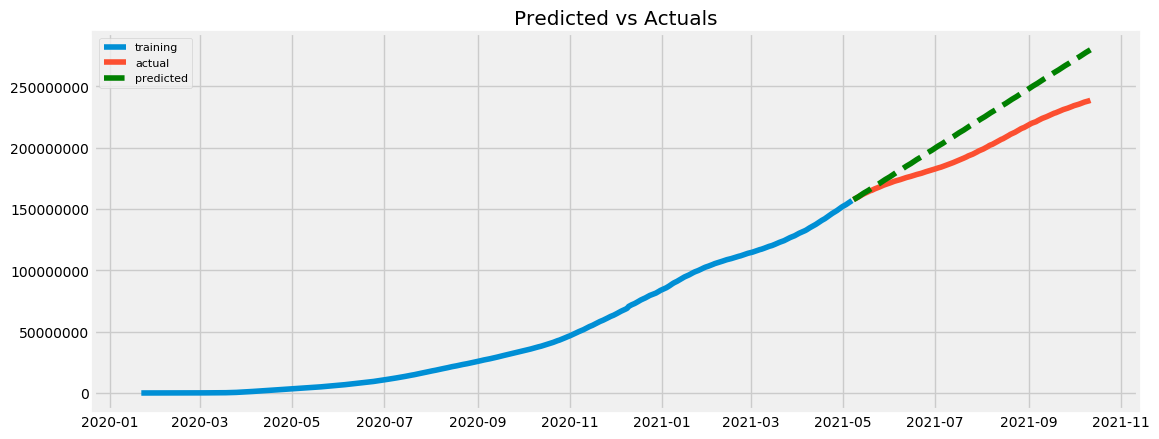

In [15]:
# make series for plotting purpose
# We see that the values are way off, just as we predicted. With a model other than Arima(1,1,1), it gets a reduced AIC score
# but fails to improve the RMSE and MAPE whcih we are more focused on
pred_series = pd.Series(pred_train, index=x_test)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(train, label='training')
plt.plot(y_test, label='actual')
plt.plot(pred_series, label='predicted', linestyle='dashed', color = "green")

plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Run the model on the whole dataset and make predictions for upcoming months 
(we will stick to the predictions we made with our previous arima model. This was done for testing and curiosity purpose)

In [16]:
# We use auto_arima to select the best model, that is the values for order of difference, p, q
# The best model we get is (3,2,3), although manually we chose (1,1,1)
# We get a reduced AIC of 15587
model = auto_arima(confirmed_df2.Cases, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=15888.533, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=16012.566, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=15995.139, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=15955.820, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16010.612, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=15869.230, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=15984.946, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=15820.031, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=15937.203, Time=0.09 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=15670.744, Time=1.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=15735.082, Time=0.70 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=15591.063, Time=1.08 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=15606.672, Time=0.98 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=15587.925, Time=1.43 sec
 ARIMA(2,2,3)(0,0,0

In [17]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -7786.962
Date:                Fri, 12 Nov 2021   AIC                          15587.925
Time:                        05:20:37   BIC                          15619.023
Sample:                             0   HQIC                         15600.006
                                - 630                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0992      0.045     24.377      0.000       1.011       1.188
ar.L2         -0.8168      0.056    -14.592      0.000      -0.926      -0.707
ar.L3         -0.1425      0.044     -3.273      0.0

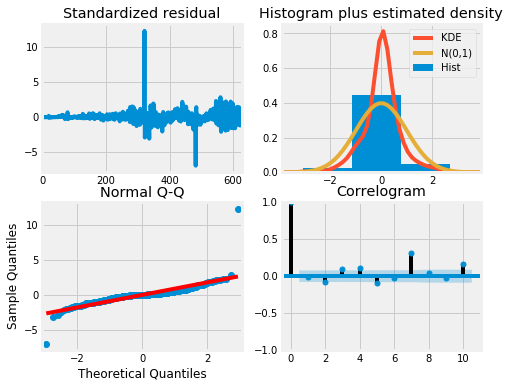

In [18]:
# We see there are some high points in the first plot. Also, we can see that some of the residual errors are autocorrelated...
# ... which means there is some pattern in the residual errors that are not explained by the model
# The histogram is slightly skewed to the left suggesting some trends not removed

# Keeping in mind that the results are biased with the manual arima model due to under-differencing. 
# But as for the scope of this class, I believe it was a good practice to... 
#... getting familiar with using some of the forecasting techniques
model.plot_diagnostics(figsize=(7,6))

plt.show()

In [19]:
from datetime import datetime

In [20]:
pred_index1 = pd.date_range(start="2021-10-13",end="2022-10-13")
len(pred_index1)

366

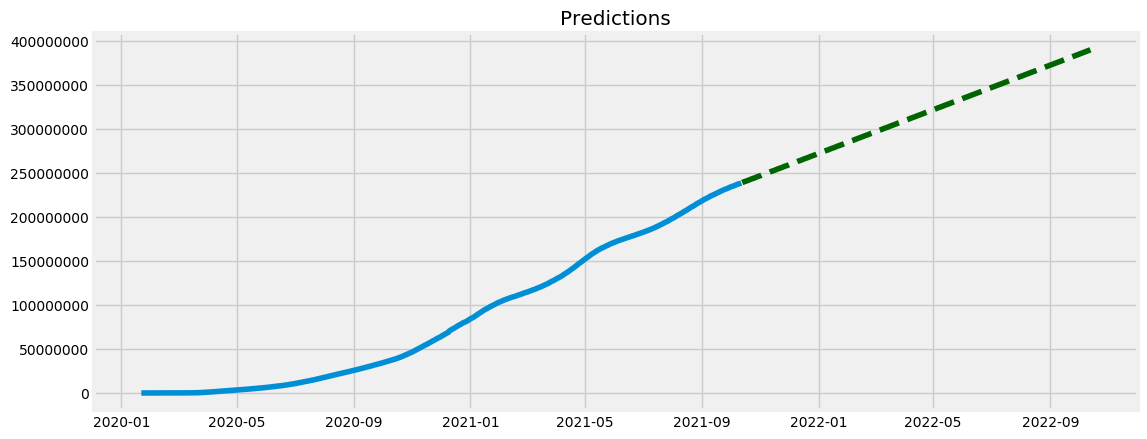

In [21]:
# PUT THIS PART AFTER THE FORECAST OF NOV 8TH, 2021 (below)
# Forecast for October 2022 
future_days = 366
pred = model.predict(n_periods=future_days)
#pred_index = np.arange(len(confirmed_df2.Cases), len(confirmed_df2.Cases)+future_days)
pred_index = pd.date_range(start="2021-10-13",end="2022-10-13")

# make series for plotting purpose
pred_series = pd.Series(pred, index=pred_index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(confirmed_df2.Cases)
plt.plot(pred_series, linestyle='dashed', color='darkgreen')

plt.title("Predictions")
plt.show()

In [24]:
# PUT THIS PART FIRST IN THE REPORT AND PRESENTATION SLIDE
# Forecast for November 8th, 2021 
# Since our dataset ended in October, we wanted to see how close the real values are with the model
# So, we decided to look at the number of cases till November 11th, 2021 (that was the time we were done with the project)
# We checked the number of gloabl cases that day and saw the value of ~250 million
# Once we run our model and compute the maximum value for the 27 days
# we see the value of 249 million; 249,848,643 to be precise. 
# This is pretty close and accurate; enough to make us satisfied with our model
pred_index = pd.date_range(start="2021-10-13",end="2021-11-12")
future_days = len(pred_index)
pred = model.predict(n_periods=future_days)
max(pred)

251670367.9165869

In [25]:
#Get the 11th day of November (which will be the last day of the array)
pred[-1]

251670367.9165869